In [1]:
import pandas as pd
import numpy as np
from trading_rule import *
import matplotlib.pyplot as plt

In [2]:
data_path = f'Data/Forex/EURUSD.csv'
data = pd.read_csv(data_path)

In [3]:
data.set_index('Datetime',inplace=True)
data.sort_index(ascending=True,inplace=True)

In [4]:
def store_rule(rule_obj:TradingRule,signals,bisignals,pnls):
  signals.append(rule_obj.signal)
  bisignals.append(rule_obj.bisignal)
  pnls.append(rule_obj.pnl)

In [5]:
from itertools import product
signals = []
bisignals = []
pnls = []

lookbacks = [6*2**i for i in range(6)]

for lookback in lookbacks:
  for thr in [0.85,0.95,0.99]:
    store_rule(ChannelBreakout(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(SkewPremium(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(KurtReversal(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
  for thr in [1,2,3]:
    store_rule(EWMAC(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(BollingerBand(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
    store_rule(NDayMomentum(lookback,thr,
                    data.Open,data.High,data.Low,data.Close,data.Volume),
              signals,bisignals,pnls)
  

In [6]:
signals_df = pd.concat(signals,axis=1).dropna()
bisignals_df = pd.concat(bisignals,axis=1).dropna()
pnls_df = pd.concat(pnls,axis=1).dropna()

In [7]:
def sr(pnl):
  pnl = pnl.fillna(0)
  mu = pnl.mean()
  sig = pnl.std()
  n_per_year = 24*252
  sr = mu/sig*n_per_year**0.5
  return sr

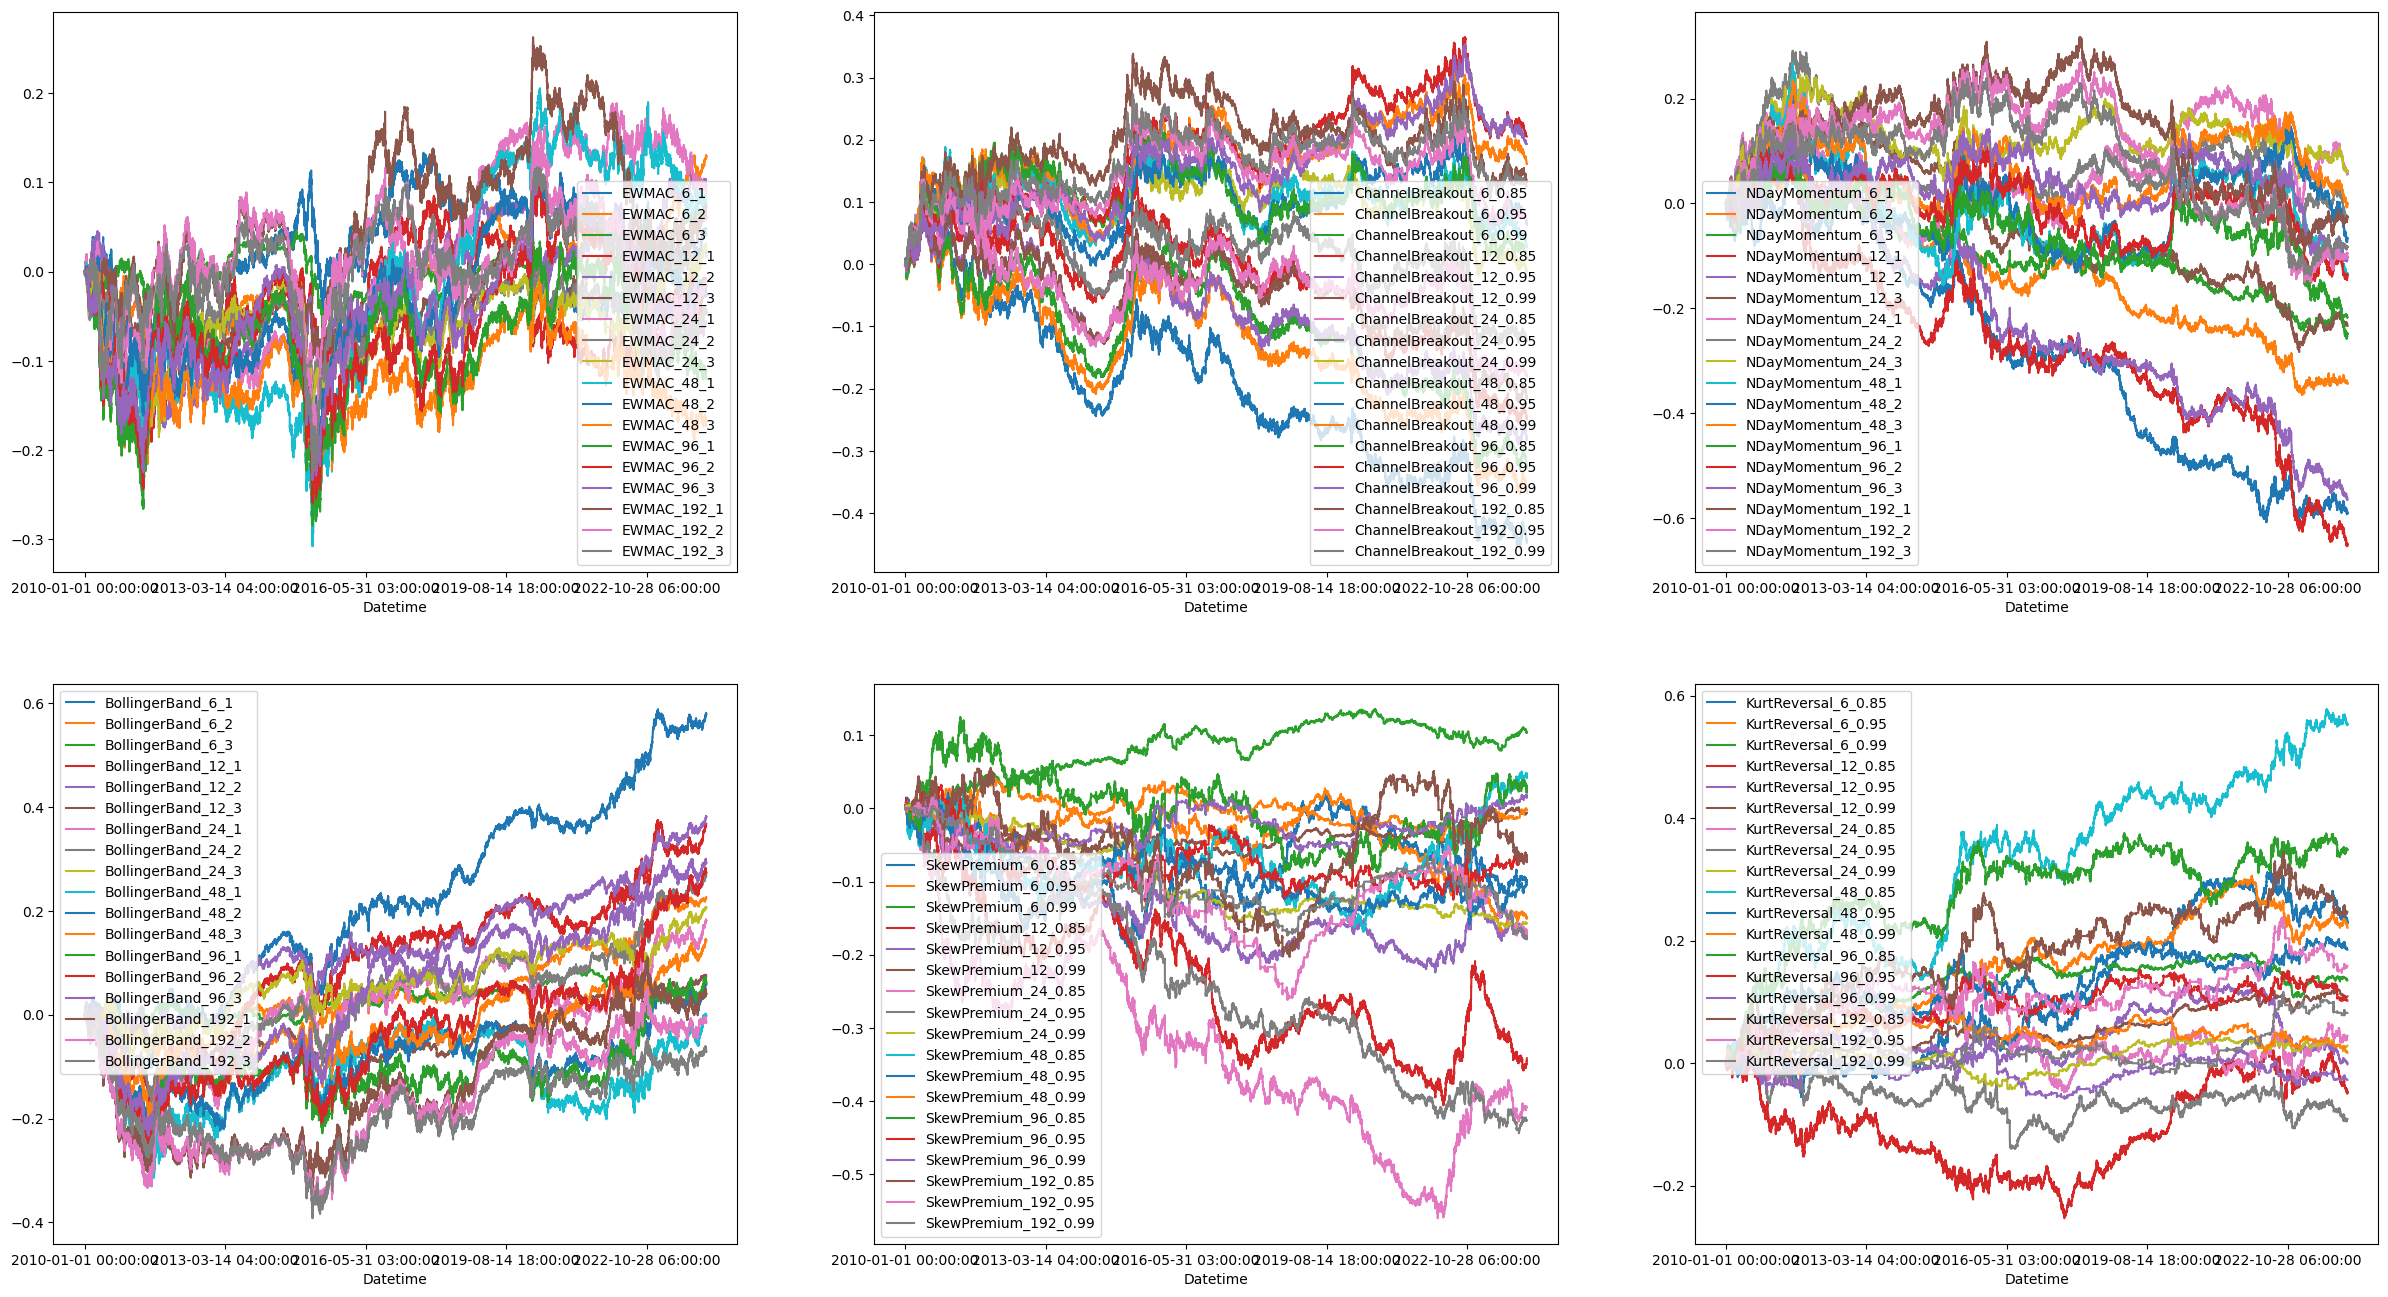

In [8]:
strats = ['EWMAC','ChannelBreakout','NDayMomentum','BollingerBand','SkewPremium','KurtReversal']

fig,axes = plt.subplots(2,3,figsize=(30,16))
for i,strat in enumerate(strats):
  cols = pnls_df.columns[pnls_df.columns.str.match(f'{strat}_*')]
  ax = axes[i//3,i%3]
  pnls_df.loc[:,cols].cumsum().plot(ax=ax)

# KMean

In [9]:
from sklearn.cluster import KMeans

In [10]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
kmeans.fit(pnls_df.corr())
groups = kmeans.labels_

port = {i: list() for i in range(n_clusters)}
for i,group in enumerate(groups):
  port[group].append(pnls_df.columns[i])

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


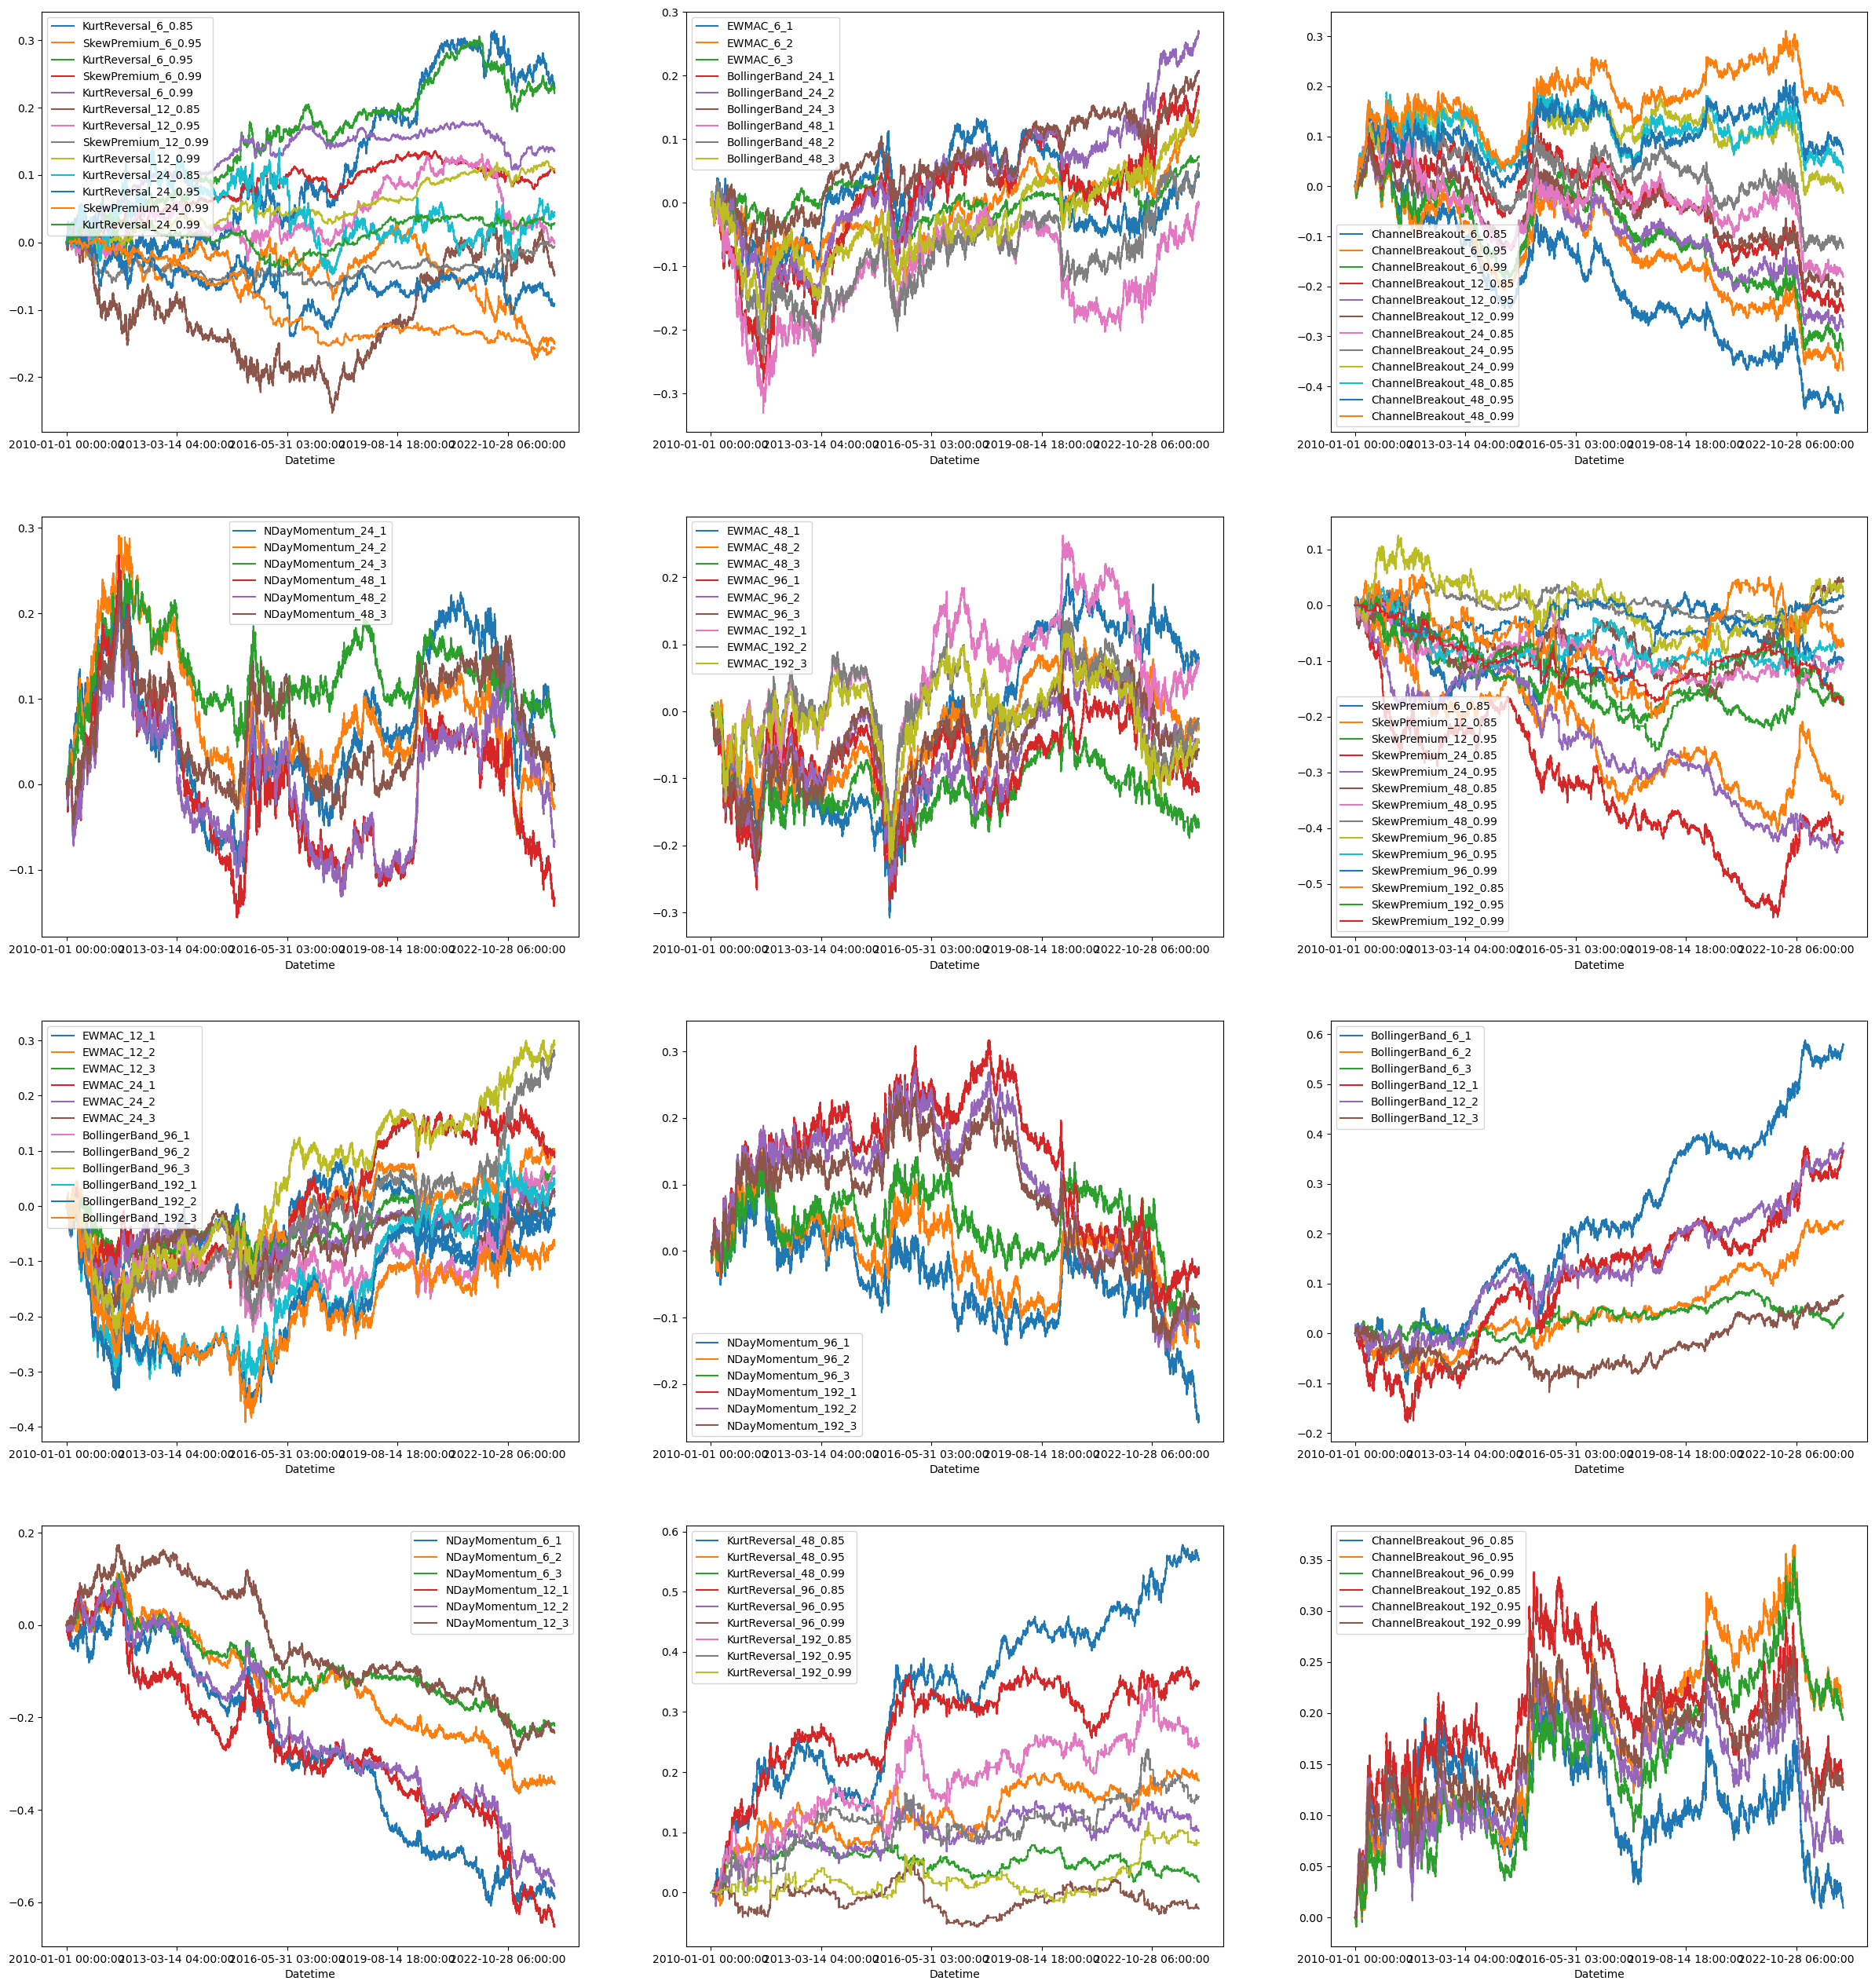

In [11]:
fig,axes = plt.subplots(4,3,figsize=(30,32))
for i,s_list in (port.items()):
  ax = axes[i//3,i%3]
  pnls_df.loc[:,s_list].cumsum().plot(ax=ax)

# Labelling

In [12]:
def get_label(prc, tp, sl, hd):
    log_prc = np.log(prc)
    log_ret = log_prc.diff().shift(-1)
    ew_vol = np.sqrt((log_ret**2).ewm(40, min_periods=40).mean())

    # tp = window**0.5
    # sl = window**0.5
    # hd = window

    # print(tp , sl , hd)
    label = []

    for i, ret in log_ret.items():
        up_bar = ew_vol.loc[i] * tp
        low_bar = ew_vol.loc[i] * -sl
        time_bar = hd

        future_ret = log_ret.loc[i:]
        cum_ret = ret
        cum_day = 1
        while True:
            if cum_ret >= up_bar:
                label.append(cum_ret)
                break
            elif cum_ret <= low_bar:
                label.append(cum_ret)
                break
            elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
                label.append(cum_ret)
                break

            ret = future_ret.iloc[cum_day]
            cum_day += 1
            cum_ret += ret

    label = pd.Series(np.where(np.array(label)>=0,1,-1), index=log_ret.index, name="LABEL")
    return label

In [13]:
tp,sl,hd = 2,1,24
label = get_label(data.Close,tp,sl,hd)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from statsmodels.api import OLS

from numpy.lib.stride_tricks import sliding_window_view

In [15]:
def get_pred(dataset):
    #dataset = dataset[0,0]
    #print(dataset)
    train_set = dataset[:, :-1]
    test_set = dataset[:, -1]
    train_y, train_x = train_set[0], train_set[1:]
    test_y, test_x = test_set[0], test_set[1:]
    #model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=300300)
    model = LogisticRegression(penalty='l2',random_state=300300)
    model.fit(y=train_y, X=train_x.T)
    pred = model.predict(test_x.reshape(1, -1))[0]
    return pred

In [16]:
p = pd.concat([label,signals_df.loc[:,port[0]]],axis=1).dropna()
lookback = 2400

# create rolling datasets for each day
rolling = sliding_window_view(p,axis=0, window_shape=lookback+1)
# random forest prediction
#pred = np.apply_over_axis(get_pred, axis=1, arr=rolling)
size = 80000
pred = [get_pred(dataset) for dataset in rolling[:size]]
pred_d = pd.Series(pred,p.index[lookback+1:lookback+1+size])

In [21]:
sr(pred_d * data.Close.diff().shift(-1))

0.2158255343408072

<Axes: xlabel='Datetime'>

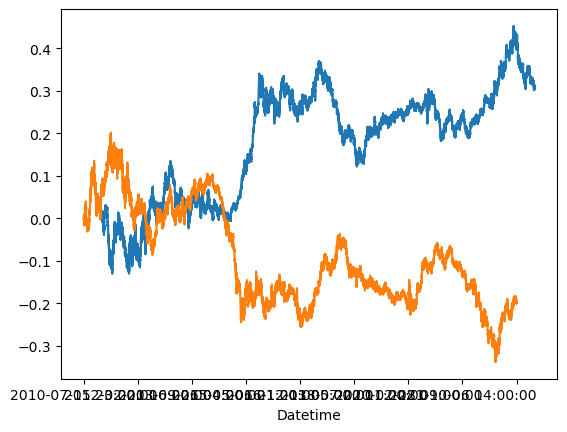

In [18]:
(pred_d * data.Close.diff().shift(-1)).cumsum().plot()
data.Close.diff().shift(-1).loc[pred_d.index].cumsum().plot()

In [187]:
pred_d = pd.Series(pred,p.index[2401:2401+5000])
pred_d.tail()

Datetime
2011-05-04 02:00:00   -1.0
2011-05-04 03:00:00   -1.0
2011-05-04 04:00:00   -1.0
2011-05-04 05:00:00   -1.0
2011-05-04 06:00:00   -1.0
dtype: float64

In [136]:
vf = np.vectorize(lambda x: print(x))
vf(rolling[:1])

1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1

array([[[None, None, None, ..., None, None, None],
        [None, None, None, ..., None, None, None],
        [None, None, None, ..., None, None, None],
        ...,
        [None, None, None, ..., None, None, None],
        [None, None, None, ..., None, None, None],
        [None, None, None, ..., None, None, None]]], dtype=object)

In [131]:
vget_pred = np.vectorize(get_pred)
vget_pred(rolling[:2])

1.0


IndexError: invalid index to scalar variable.

In [89]:
r1[:,-10:]

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        , -1.        , -1.        , -1.        , -1.        ],
       [ 0.16666667,  0.41666667,  0.29166667,  0.41666667,  0.41666667,
         0.375     ,  0.625     ,  0.20833333,  0.125     ,  0.16666667],
       [ 0.41666667,  0.75      ,  0.70833333,  0.75      ,  0.54166667,
         0.25      ,  0.625     ,  0.33333333,  0.25      ,  0.20833333],
       [ 0.16666667,  0.41666667,  0.29166667,  0.41666667,  0.41666667,
         0.375     ,  0.625     ,  0.20833333,  0.125     ,  0.16666667],
       [ 0.41666667,  0.75      ,  0.70833333,  0.75      ,  0.54166667,
         0.25      ,  0.625     ,  0.33333333,  0.25      ,  0.20833333],
       [ 0.16666667,  0.41666667,  0.29166667,  0.41666667,  0.41666667,
         0.375     ,  0.625     ,  0.20833333,  0.125     ,  0.16666667],
       [ 0.52083333,  0.66666667,  0.64583333,  0.625     ,  0.625     ,
         0.70833333,  0.4375    ,  0.54166667

In [90]:
p.iloc[2391:2401]

LABEL  S_KurtReversal_6_0.85  S_SkewPremium_6_0.95  \
Datetime                                                                  
2010-07-15 13:00:00    1.0               0.166667              0.416667   
2010-07-15 14:00:00    1.0               0.416667              0.750000   
2010-07-15 15:00:00    1.0               0.291667              0.708333   
2010-07-15 16:00:00    1.0               0.416667              0.750000   
2010-07-15 17:00:00    1.0               0.416667              0.541667   
2010-07-15 18:00:00    1.0               0.375000              0.250000   
2010-07-15 19:00:00   -1.0               0.625000              0.625000   
2010-07-15 20:00:00   -1.0               0.208333              0.333333   
2010-07-15 21:00:00   -1.0               0.125000              0.250000   
2010-07-15 22:00:00   -1.0               0.166667              0.208333   

                     S_KurtReversal_6_0.95  S_SkewPremium_6_0.99  \
Datetime                                                           
2010-07-15 13:00:00               0.166667              0.416667   
2010-07-15 14:00:00               0.416667              0.750000   
2010-07-15 15:00:00               0.291667              0.708333   
2010-07-15 16:00:00               0.416667              0.750000   
2010-07-15 17:00:00               0.416667              0.541667   
2010-07-15 18:00:00               0.375000              0.250000   
2010-07-15 19:00:00               0.625000              0.625000   
2010-07-15 20:00:00               0.208333              0.333333   
2010-07-15 21:00:00               0.125000              0.250000   
2010-07-15 22:00:00               0.166667              0.208333   

                     S_KurtReversal_6_0.99  S_KurtReversal_12_0.85  \
Datetime                                                             
2010-07-15 13:00:00               0.166667                0.520833   
2010-07-15 14:00:00               0.416667                0.666667   
2010-07-15 15:00:00               0.291667                0.645833   
2010-07-15 16:00:00               0.416667                0.625000   
2010-07-15 17:00:00               0.416667                0.625000   
2010-07-15 18:00:00               0.375000                0.708333   
2010-07-15 19:00:00               0.625000                0.437500   
2010-07-15 20:00:00               0.208333                0.541667   
2010-07-15 21:00:00               0.125000                0.479167   
2010-07-15 22:00:00               0.166667                0.479167   

                     S_KurtReversal_12_0.95  S_SkewPremium_12_0.99  \
Datetime                                                             
2010-07-15 13:00:00                0.520833               0.750000   
2010-07-15 14:00:00                0.666667               0.895833   
2010-07-15 15:00:00                0.645833               0.895833   
2010-07-15 16:00:00                0.625000               0.812500   
2010-07-15 17:00:00                0.625000               0.729167   
2010-07-15 18:00:00                0.708333               0.729167   
2010-07-15 19:00:00                0.437500               0.375000   
2010-07-15 20:00:00                0.541667               0.354167   
2010-07-15 21:00:00                0.479167               0.104167   
2010-07-15 22:00:00                0.479167               0.354167   

                     S_KurtReversal_12_0.99  S_KurtReversal_24_0.85  \
Datetime                                                              
2010-07-15 13:00:00                0.520833                0.354167   
2010-07-15 14:00:00                0.666667                0.541667   
2010-07-15 15:00:00                0.645833                0.614583   
2010-07-15 16:00:00                0.625000                0.614583   
2010-07-15 17:00:00                0.625000                0.593750   
2010-07-15 18:00:00                0.708333                0.635417   
2010-07-15 19:00:00                0.437500          

S_KurtReversal_6_0.85  S_SkewPremium_6_0.95  \
Datetime                                                           
2010-02-25 23:00:00               0.916667              1.000000   
2010-02-26 00:00:00               0.291667              0.750000   
2010-02-26 01:00:00               0.833333              0.958333   
2010-02-26 02:00:00               1.000000              1.000000   
2010-02-26 03:00:00               0.916667              0.916667   
...                                    ...                   ...   
2024-03-08 20:00:00               0.583333              0.333333   
2024-03-08 21:00:00               0.583333              0.333333   
2024-03-10 21:00:00               0.208333              0.541667   
2024-03-10 22:00:00               0.166667              0.541667   
2024-03-10 23:00:00               0.125000              0.416667   

                     S_KurtReversal_6_0.95  S_SkewPremium_6_0.99  \
Datetime                                                           
2010-02-25 23:00:00               0.916667              1.000000   
2010-02-26 00:00:00               0.291667              0.750000   
2010-02-26 01:00:00               0.833333              0.958333   
2010-02-26 02:00:00               1.000000              1.000000   
2010-02-26 03:00:00               0.916667              0.916667   
...                                    ...                   ...   
2024-03-08 20:00:00               0.583333              0.333333   
2024-03-08 21:00:00               0.583333              0.333333   
2024-03-10 21:00:00               0.208333              0.541667   
2024-03-10 22:00:00               0.166667              0.541667   
2024-03-10 23:00:00               0.125000              0.416667   

                     S_KurtReversal_6_0.99  S_KurtReversal_12_0.85  \
Datetime                                                             
2010-02-25 23:00:00               0.916667                0.562500   
2010-02-26 00:00:00               0.291667                0.604167   
2010-02-26 01:00:00               0.833333                0.458333   
2010-02-26 02:00:00               1.000000                0.270833   
2010-02-26 03:00:00               0.916667                0.437500   
...                                    ...                     ...   
2024-03-08 20:00:00               0.583333                0.729167   
2024-03-08 21:00:00               0.583333                0.729167   
2024-03-10 21:00:00               0.208333                0.604167   
2024-03-10 22:00:00               0.166667                0.604167   
2024-03-10 23:00:00               0.125000                0.500000   

                     S_KurtReversal_12_0.95  S_SkewPremium_12_0.99  \
Datetime                                                             
2010-02-25 23:00:00                0.562500               0.416667   
2010-02-26 00:00:00                0.604167               0.312500   
2010-02-26 01:00:00                0.458333               0.166667   
2010-02-26 02:00:00                0.270833               0.375000   
2010-02-26 03:00:00                0.437500               0.416667   
...                                     ...                    ...   
2024-03-08 20:00:00                0.729167               0.625000   
2024-03-08 21:00:00                0.729167               0.625000   
2024-03-10 21:00:00                0.604167               0.520833   
2024-03-10 22:00:00                0.604167               0.541667   
2024-03-10 23:00:00                0.500000               0.437500   

                     S_KurtReversal_12_0.99  S_KurtReversal_24_0.85  \
Datetime                                                              
2010-02-25 23:00:00                0.562500                0.593750   
2010-02-26 00:00:00                0.604167                0.739583   
2010-02-26 01:00:00                0.458333                0.489583   
2010-02-26 02:00:00                0.270833                0.541667   
201

# AggClust

In [92]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [93]:
def plot_dendrogram(model,ax):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,ax=ax)

In [94]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(pnls_df.corr())

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [95]:
model.n_clusters_

192

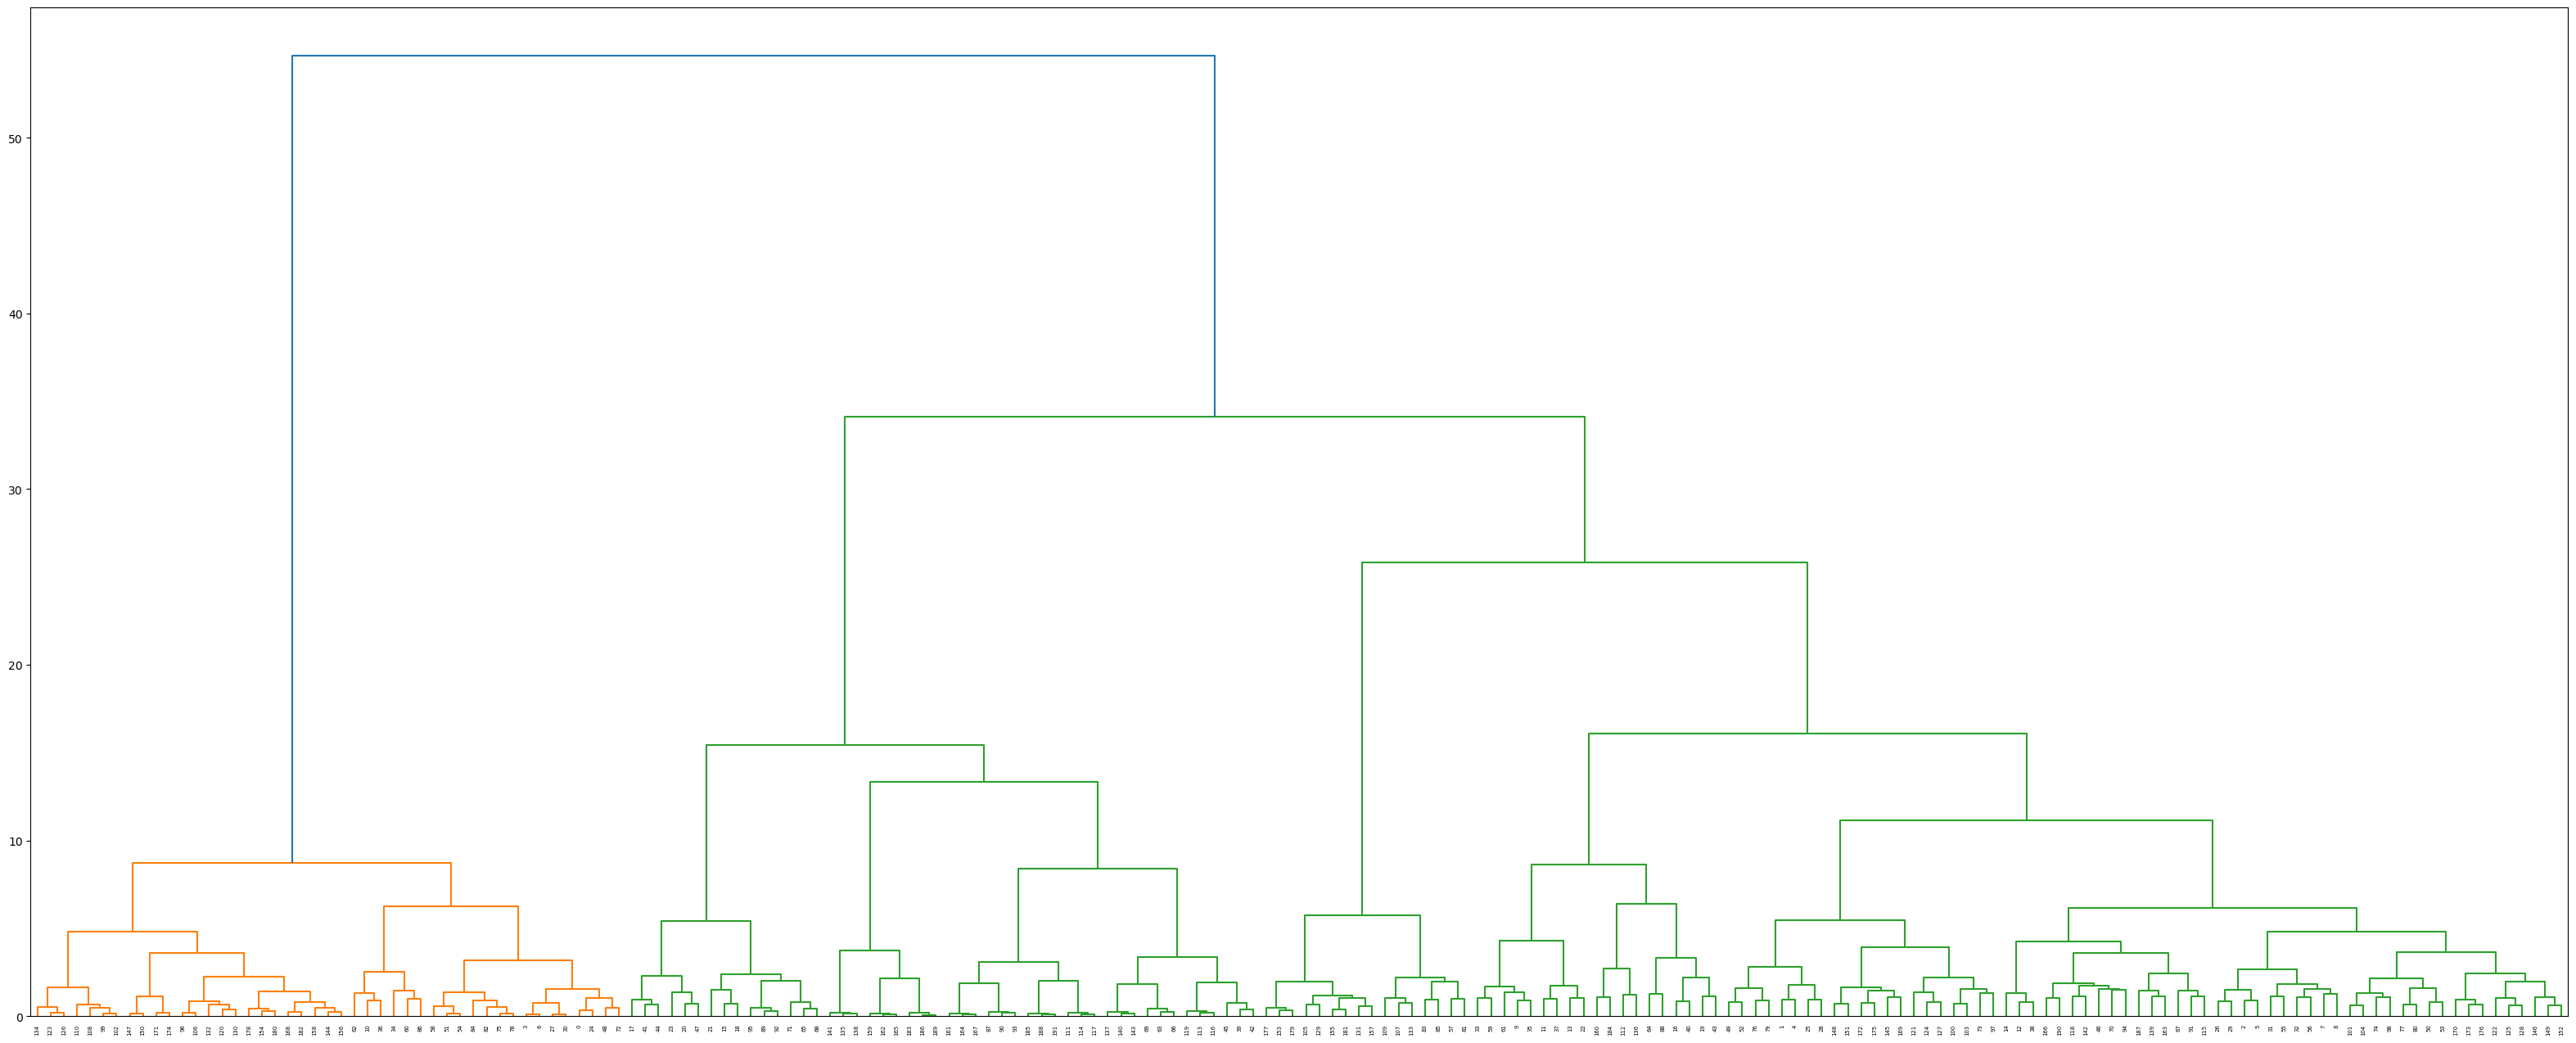

In [26]:
fig,ax = plt.subplots(figsize=(40,16))
plot_dendrogram(model,ax=ax)

# HRP

In [8]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [9]:
hrp = HRPOpt(pnls_df)

In [10]:
hrp.optimize()

OrderedDict([('P_BollingerBand_12_1', 4.965419272507785e-06),
             ('P_BollingerBand_12_2', 1.141890294472937e-05),
             ('P_BollingerBand_12_3', 5.918875734583587e-05),
             ('P_BollingerBand_192_1', 2.8149911085109723e-06),
             ('P_BollingerBand_192_2', 6.482406671313592e-06),
             ('P_BollingerBand_192_3', 3.335117948611472e-06),
             ('P_BollingerBand_24_1', 5.815536425951956e-06),
             ('P_BollingerBand_24_2', 6.304609392538037e-06),
             ('P_BollingerBand_24_3', 7.631948515761401e-06),
             ('P_BollingerBand_384_1', 4.065718471373458e-06),
             ('P_BollingerBand_384_2', 4.3025320429956075e-06),
             ('P_BollingerBand_384_3', 1.6997115776264173e-05),
             ('P_BollingerBand_48_1', 2.9577884986447482e-06),
             ('P_BollingerBand_48_2', 7.400602059360498e-06),
             ('P_BollingerBand_48_3', 4.498406540079781e-06),
             ('P_BollingerBand_6_1', 8.793287355404795e-06),

In [12]:
hrp.portfolio_performance(risk_free_rate=0,frequency=252*24)

(-0.0001824357287829505, 0.0007505623064044045, -0.24306540206757163)